In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_miniodb.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_miniodbtest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 10].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 10].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,9.958133,0.000000,0.000000,2.922424e+03,0.019789,8.295819e+02,891.377388,1.0,16.0,0.912022,2.0,63.873122,1.240458e+10,7.330045
1,13.589864,0.006419,922.528427,8.798615e+04,0.019789,7.448670e+05,6527.744480,1.0,32.0,0.905742,6.0,63.873122,1.240458e+10,37.569958
2,13.539800,0.151911,1001.244444,1.183198e+07,0.019789,3.649453e+06,15798.111111,1.0,49.0,0.888829,6.0,26.283558,1.240458e+10,37.569958
3,5.633917,0.151914,1001.266695,1.183060e+07,0.203466,3.661378e+06,16975.310562,1.0,65.0,0.901064,6.0,26.283558,1.240458e+10,37.396603
4,7.244292,0.146933,273.066667,1.176899e+07,0.203466,3.087269e+06,13670.911111,1.0,66.0,0.893493,6.0,23.183333,1.240458e+10,37.396603


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,0.855900,90.926165,0.912022,16.0
1,2.567700,466.039717,0.905742,32.0
2,1.056599,466.039717,0.888829,49.0
3,1.056599,463.889317,0.901064,65.0
4,0.931970,463.889317,0.893493,66.0


In [6]:
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
#x_train = preprocessing.normalize(x_train, norm='max')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
#x_test = preprocessing.normalize(x_test, norm='max')

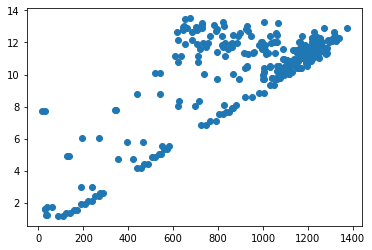

In [7]:
plt.scatter(df_ttest['requests'], df_ttest['total_cpu_util'] )

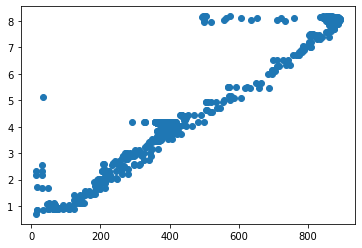

In [8]:
plt.scatter(df_t['requests'], df_t['total_cpu_util'] )

## Linear Regression

Training Score  0.9551818496719733
Testing Score  0.3505800618920598


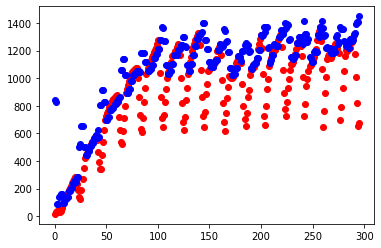

In [9]:
parameters = {'fit_intercept': [True,False],
             'copy_X': [True,False]}
#linear = GridSearchCV(LinearRegression(),
#                      parameters, 
#                      cv=7,
#                      scoring='r2',
#                      n_jobs=-1)
linear = LinearRegression(fit_intercept=False)
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)
y_te_pred = linear.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",linear.score(x_train,y_train))
print("Testing Score ",linear.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', linear.best_score_)
#print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

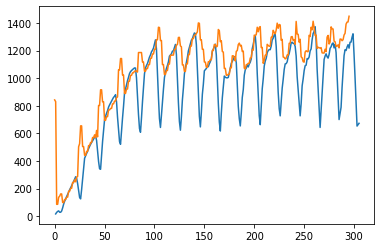

In [10]:
plt.plot(y_test)
plt.plot(y_te_pred)

## Polynomial Regression

Training Score  0.9628209746685472
Testing Score  0.33179243786541435
Best Params:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}


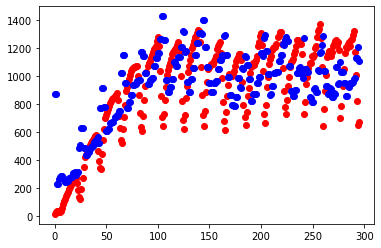

In [11]:
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [2,3,4,5,6 ]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      cv=5,
                      scoring='r2',
                      n_jobs=-1)
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)
y_te_pred = polynomial.predict(x_test)

#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",polynomial.score(x_train,y_train))
print("Testing Score ",polynomial.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Ridge Regression

Training Score  0.9551818491310303
Testing Score  0.35062166792952454
Best Params:  {'alpha': 0.08858667904100796, 'fit_intercept': False, 'max_iter': 10, 'solver': 'auto'}


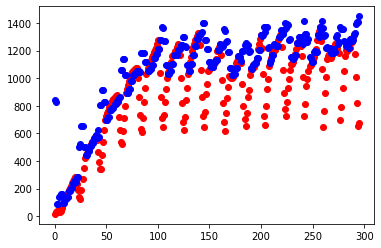

In [12]:
alphas = np.logspace(-20,10,num=20)
param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
            'solver': ['auto', 'svd'],
             'fit_intercept':[True, False]}
ridge_cv = GridSearchCV(Ridge(),
                       param_grid=param_grid,
                         cv=3, 
                         scoring='r2',
                         n_jobs=-1)

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)
y_te_pred = ridge_cv.predict(x_test)

print("Training Score ",ridge_cv.score(x_train,y_train))
print("Testing Score ",ridge_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Lasso Regression

Fitting 3 folds for each of 5760 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2696 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 6696 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 12296 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  1.4min finished


Training Score  0.9551754946113019
Testing Score  0.35352671751599163
Best Params:  {'alpha': 7.847599703514623e-13, 'copy_X': True, 'fit_intercept': False, 'max_iter': 60, 'positive': False, 'selection': 'random', 'warm_start': False}


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1373487.138315363, tolerance: 29609.438100000003
  positive)


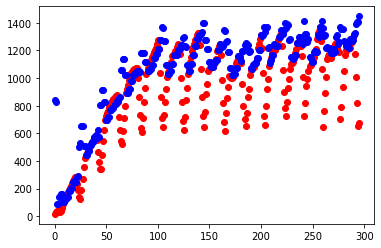

In [13]:
alphas = np.logspace(-20,10,num=20)

param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
             'fit_intercept':[True, False],
             'selection': ['cyclic', 'random'],
             'positive':[True, False],
             'warm_start':[True, False],
             'copy_X':[True, False]}

lasso_cv = GridSearchCV(Lasso(),
                       param_grid=param_grid,
                         cv=3, 
                        scoring='r2',
                         n_jobs=-1,
                       verbose=1)

lasso_cv.fit(x_train, y_train)

y_tr_pred = lasso_cv.predict(x_train)
y_te_pred = lasso_cv.predict(x_test)

print("Training Score ",lasso_cv.score(x_train,y_train))
print("Testing Score ",lasso_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', lasso_cv.best_score_)
print('Best Params: ', lasso_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Huber Regressor

Fitting 3 folds for each of 7200 candidates, totalling 21600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 3944 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6056 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8656 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 11656 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 15056 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 18856 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 21600 out of 21600 | elapsed:  7.3min finished
/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

Training Score  0.9538843015849439
Testing Score  0.2798932948402336
Best Params:  {'alpha': 6.15848211066028e-05, 'epsilon': 1.4500000000000004, 'fit_intercept': True, 'max_iter': 50, 'warm_start': True}


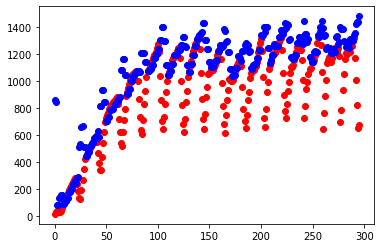

In [14]:
epsilon = np.arange(1, 1.5, 0.05)

param_grid = {'max_iter': np.arange(10,100,10),
             'alpha': alphas,
              'epsilon': epsilon,
             'fit_intercept':[True, False],
             'warm_start':[True, False]}

huber_cv = GridSearchCV(HuberRegressor(),
                       param_grid=param_grid,
                         cv=3, 
                         scoring='r2',
                         n_jobs=-1,
                       verbose=1)

huber_cv.fit(x_train, y_train)

y_tr_pred = huber_cv.predict(x_train)
y_te_pred = huber_cv.predict(x_test)

print("Training Score ",huber_cv.score(x_train,y_train))
print("Testing Score ",huber_cv.score(x_test,y_test))



#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', huber_cv.best_score_)
print('Best Params: ', huber_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Random Forrest Regressor

Training Score  0.9856617375917154
Testing Score  -0.7889913060925193
Best Params:  {'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100}


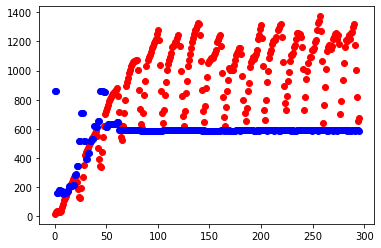

In [15]:
parameters = {  
                 'min_samples_leaf': [2, 4, 6],
                 'max_depth': np.arange(1,6,1),
                 'n_estimators': [100],
                'max_features': ['auto']
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      cv=3, 
                      scoring='r2',
                      n_jobs=-1)

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)
y_te_pred = rf_cv.predict(x_test)


print("Training Score ",rf_cv.score(x_train,y_train))
print("Testing Score ",rf_cv.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

Test R² : -0.7748476145971377
Train R² : 0.9876761119698054


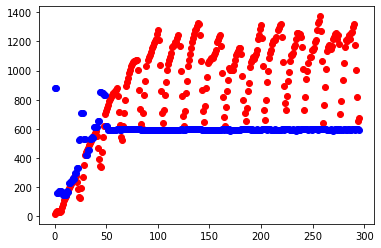

In [16]:
finalrf_cv = RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=150)
finalrf_cv.fit(x_train, y_train)
y_tr_pred = finalrf_cv.predict(x_train)
y_te_pred = finalrf_cv.predict(x_test)

from sklearn.metrics import r2_score
R = r2_score(y_test, y_te_pred)
print ('Test R² :',R)

R = r2_score(y_train, y_tr_pred)
print ('Train R² :',R)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## ElasticNet

Training Score  0.9552733256841934
Testing Score  0.36384255625064565
Best Params:  {'alpha': 0.08858667904100796, 'l1_ratio': 0.8}


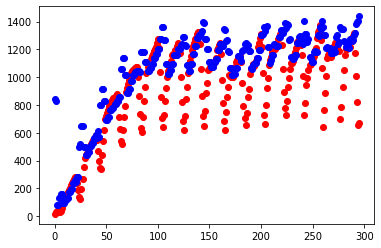

In [17]:
# find optimal alpha with grid search
alpha = np.logspace(-20,10,num=20)
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(ElasticNet(), 
                    param_grid=param_grid,
                    cv=7,
                    scoring='r2', 
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train)

y_tr_pred = grid.predict(x_train)
y_te_pred = grid.predict(x_test)

print("Training Score ",grid_result.score(x_train,y_train))
print("Testing Score ",grid_result.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')

## Gradient Boosting Regressor

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 61.4min finished


Training Score  0.9552733256841934
Testing Score  0.36384255625064565
Best Params:  {'learning_rate': 0.02, 'loss': 'ls', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 1500}


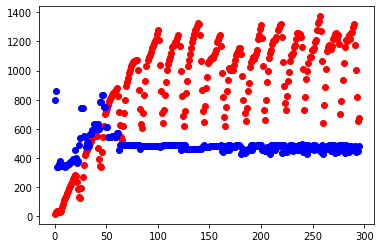

In [18]:
learning_rate = np.arange(0,0.2,0.001)
parameters = {  
                 'learning_rate': [0.02],
                 'min_samples_split': [10, 15, 20],
                 'min_samples_leaf': [10, 15, 20],
                 'max_depth': [3, 4, 5],
                 'n_estimators': [1000, 1500, 2000],
                 'loss': ['ls', 'lad', 'huber', 'quantile'],
                 'max_features': ['sqrt']
             }


GBoost_cv = GridSearchCV(GradientBoostingRegressor(), 
                         param_grid=parameters, 
                         n_jobs=-1, 
                         scoring='r2',
                         cv=5,
                        verbose=1)
#GBoost_cv = GradientBoostingRegressor(learning_rate=0.02)

GBoost_cv.fit(x_train, y_train)

y_tr_pred = GBoost_cv.predict(x_train)
y_te_pred = GBoost_cv.predict(x_test)

print("Training Score ",grid_result.score(x_train,y_train))
print("Testing Score ",grid_result.score(x_test,y_test))

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', GBoost_cv.best_score_)
print('Best Params: ', GBoost_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(y_te_pred)),y_te_pred, color='blue')